## **Clasificación de Enfermedades en Hojas de Papa (Solanum tuberosum)**

| Aspecto                   | Descripción                                                        |
| ------------------------- | ------------------------------------------------------------------ |
| **Cultivo**               | Papa (*Solanum tuberosum* L.) - 4to alimento básico mundial        |
| **Impacto económico**     | Pérdidas del 20-40% de la cosecha global por enfermedades foliares |
| **Detección tradicional** | Visual por expertos agrónomos - lenta, subjetiva, no escalable     |
| **Solución propuesta**    | Sistema de visión por computadora con deep learning                |


### **Descripción del Problema de Clasificación**

| Código | Clase                   | Descripción patológica | Causa                             |
| ------ | ----------------------- | ---------------------- | --------------------------------- |
| 0      | `Potato___Early_blight` | Tizón temprano         | Hongo *Alternaria solani*         |
| 1      | `Potato___Late_blight`  | Tizón tardío           | Oomyceto *Phytophthora infestans* |
| 2      | `Potato___healthy`      | Hoja sana              | -                                 |


In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import random
import warnings

In [2]:
warnings.filterwarnings('ignore')

## **Visualización**

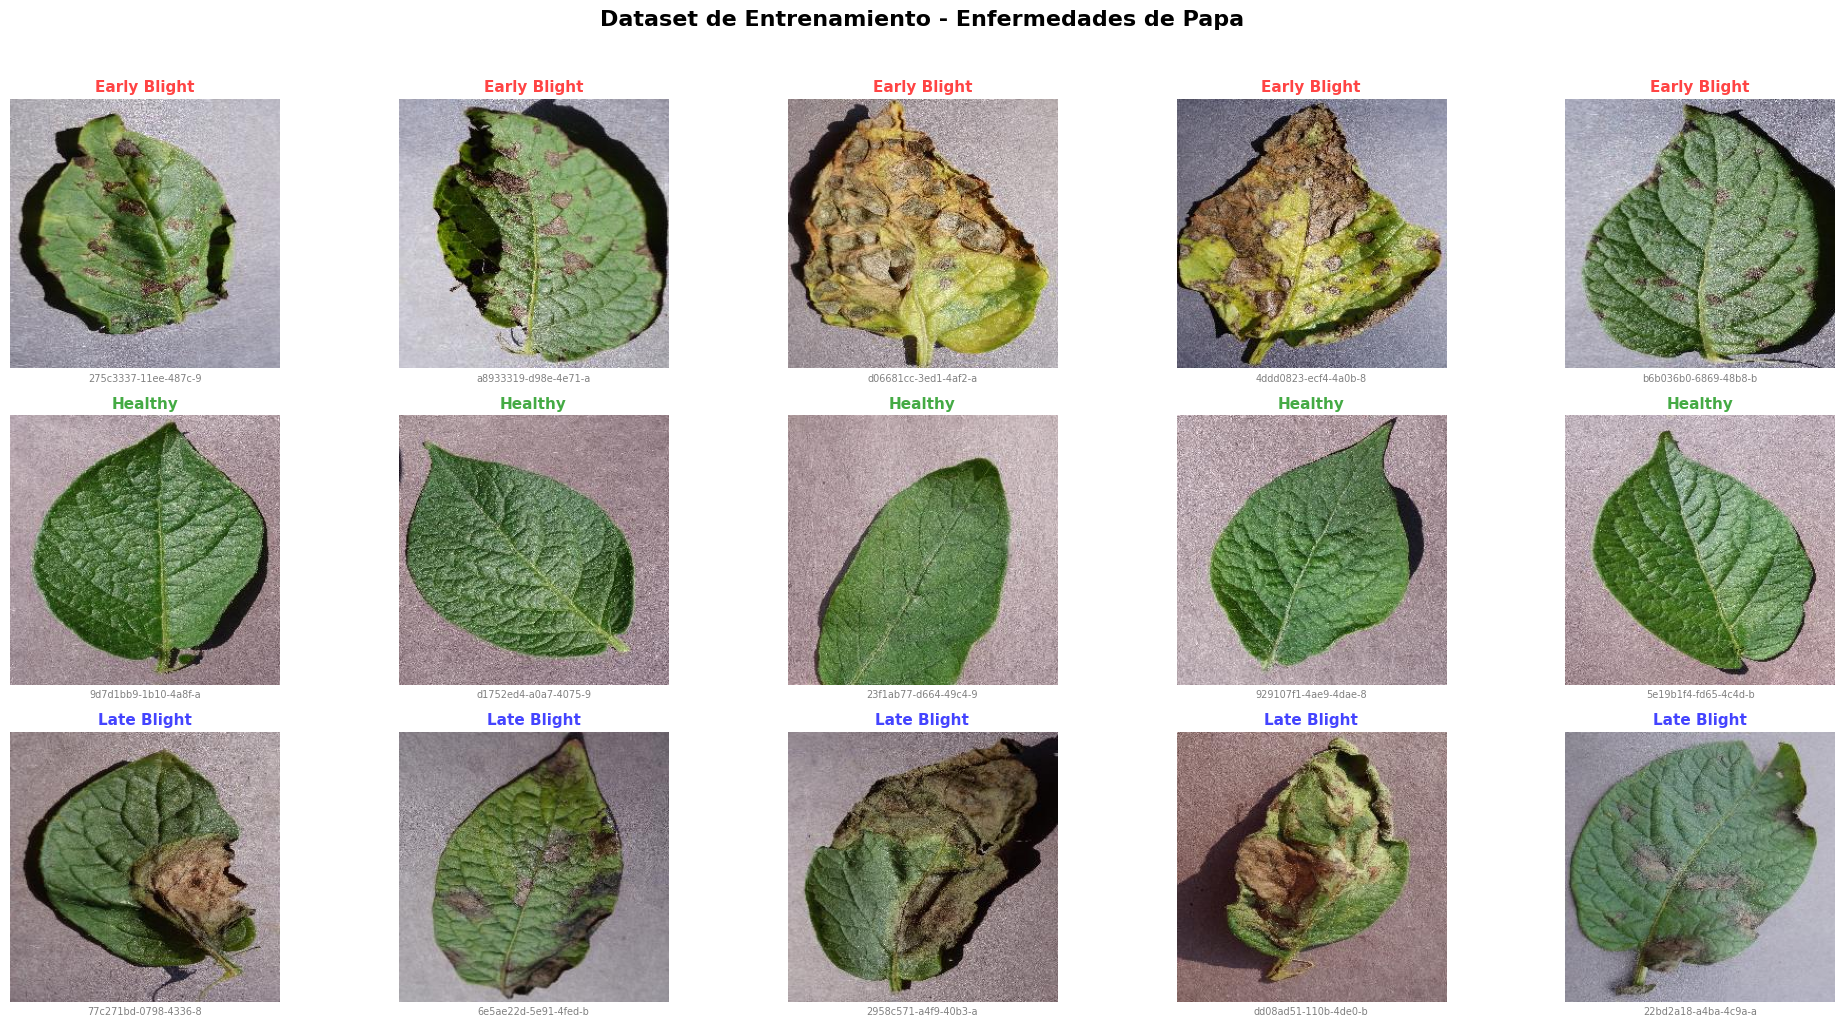

In [3]:

TRAIN_DIR = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\train"
CLASES = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# Nombres limpios para mostrar
NOMBRES_LIMPIOS = {
    'Potato___Early_blight': 'Early Blight',
    'Potato___healthy': 'Healthy',
    'Potato___Late_blight': 'Late Blight'
}

# Colores para cada clase
COLORES = {
    'Potato___Early_blight': '#FF4444',  # Rojo
    'Potato___healthy': '#44AA44',       # Verde
    'Potato___Late_blight': '#4444FF'    # Azul
}

# Crear figura
fig, axes = plt.subplots(len(CLASES), 5, figsize=(20, 10))
fig.suptitle('Dataset de Entrenamiento - Enfermedades de Papa', fontsize=16, fontweight='bold', y=1.02)

for i, clase in enumerate(CLASES):
    clase_path = os.path.join(TRAIN_DIR, clase)
    
    if not os.path.exists(clase_path):
        print(f"⚠️ No se encontró: {clase_path}")
        continue
    
    # Obtener imágenes
    imagenes = [f for f in os.listdir(clase_path) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Seleccionar 5 aleatorias
    imagenes_seleccionadas = random.sample(imagenes, min(5, len(imagenes)))
    
    for j, img_name in enumerate(imagenes_seleccionadas):
        img_path = os.path.join(clase_path, img_name)
        img = Image.open(img_path)
        
        # Mostrar imagen
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
        # ✅ TÍTULO CON NOMBRE DE LA CLASE
        nombre_clase = NOMBRES_LIMPIOS[clase]
        axes[i, j].set_title(f'{nombre_clase}', 
                            fontsize=11, 
                            fontweight='bold',
                            color=COLORES[clase],
                            pad=5)
        
        # Subtítulo con nombre de archivo
        axes[i, j].text(0.5, -0.05, img_name[:20], 
                       transform=axes[i, j].transAxes,
                       ha='center', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig('visualizacion_clases.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings

In [5]:
warnings.filterwarnings('ignore')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

## **Transformaciones de imágenes para entrenamiento y validación**

In [8]:
train_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\train"
test_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\test"
val_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\val"

In [9]:

train_transforms = transforms.Compose([
    transforms.Resize(256),           # Mantiene aspect ratio
    transforms.RandomCrop(224),       # Crop aleatorio (data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.3,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize(256),           # Mismo resize
    transforms.CenterCrop(224),       # Crop central FIJO (no random)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])


Estas transformaciones incluyen **aumentación de datos** (*data augmentation*) para mejorar la robustez del modelo y reducir el sobreajuste.

##### 1. `Resize(256)`
Redimensiona la imagen manteniendo la proporción original hasta que el lado más corto sea 256 píxeles.


##### 3. `RandomHorizontalFlip(p=0.5)`
Voltea la imagen horizontalmente con probabilidad del 50%.  
Simula variaciones naturales en la orientación.

##### 4. `RandomRotation(30)`
Rota la imagen aleatoriamente hasta ±30 grados.  
Hace al modelo más robusto a cambios de inclinación.

##### 5. `ColorJitter`
Modifica aleatoriamente propiedades visuales:

- `brightness=0.4` → brillo
- `contrast=0.4` → contraste
- `saturation=0.3` → saturación
- `hue=0.1` → tono

Esto simula variaciones de iluminación y condiciones de captura.

##### 6. `ToTensor()`
Convierte la imagen a tensor PyTorch y escala los valores de píxeles a rango [0, 1].

##### 7. `Normalize(mean, std)`
Normaliza los canales RGB usando medias y desviaciones estándar típicas de modelos preentrenados:

- mean = `[0.485, 0.456, 0.406]`
- std = `[0.229, 0.224, 0.225]`

Esto acelera el entrenamiento y mejora la estabilidad.

In [10]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_transforms)
val_dataset = ImageFolder(root=val_dir,transform=val_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## **Métrica de evaluación del modelo**

In [12]:


def accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

## **Función de pérdida del modelo**

In [13]:
def loss(model, loader, criterion):
    
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)

            outputs = model(xi)
            loss = criterion(outputs, yi)

            running_loss += loss.item()

    return running_loss / len(loader)

## **Función de entrenamiento del modelo**

In [14]:
def train(model, optimiser, epochs=100):

    train_losses = []
    val_losses = []
    train_acc_scores = []
    val_acc_scores = []

    model = model.to(device)

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for xi, yi in train_loader:

            xi = xi.to(device, dtype=torch.float32)
            yi = yi.to(device, dtype=torch.long)

            scores = model(xi)
            cost = criterion(scores, yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            running_loss += cost.item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = loss(model, val_loader, criterion)

     
        
        train_acc =  accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc_scores.append(train_acc)
        val_acc_scores.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test   Loss: {epoch_val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print("-"*50)

    return train_losses, val_losses, train_acc_scores, val_acc_scores

La función train() implementa el proceso completo de entrenamiento supervisado del modelo durante un número determinado de épocas.
En cada época, el modelo se entrena en modo train() realizando propagación hacia adelante, cálculo de la función de pérdida (CrossEntropyLoss), retropropagación del error y actualización de pesos mediante el optimizador.

Posteriormente, se calcula la pérdida promedio en el conjunto de entrenamiento y se evalúa el desempeño del modelo tanto en entrenamiento como en validación (test), obteniendo la función de pérdida y la métrica Accuracy.

La función almacena la evolución histórica de:

* Pérdida de entrenamiento

* Pérdida de validación

* Accuracy de entrenamiento

* Accuracy de validación

Finalmente, devuelve estas métricas para permitir el análisis del comportamiento del modelo, detección de overfitting y evaluación del desempeño clínico.

## **Función de evaluación del modelo**

In [15]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.squeeze().long().to(device)

        preds = model(X_batch)
        predicted = preds.argmax(dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    return all_labels,all_preds 

La función evaluate() realiza la evaluación del modelo en modo inferencia (eval()), desactivando el cálculo de gradientes para optimizar memoria y rendimiento.

Durante el proceso, recorre el conjunto de datos proporcionado (loader), obtiene las predicciones del modelo y extrae la clase predicha mediante argmax.

Posteriormente, almacena:

* Las etiquetas reales (all_labels)

* Las etiquetas predichas por el modelo (all_preds)

Finalmente, devuelve ambas listas para permitir el cálculo de métricas adicionales y la construcción de una matriz de confusión, facilitando el análisis visual de aciertos y errores del modelo.

## **Modelo**

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Si cambian dimensiones, ajustamos con conv 1x1
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.layer1 = ResidualBlock(3, 128)
        self.layer2 = ResidualBlock(128, 64, stride=2)
        self.layer3 = ResidualBlock(64, 64, stride=2)
        self.layer4 = ResidualBlock(64, 64, stride=2)
        self.layer5 = ResidualBlock(64,32,stride = 2)
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = self.pool(x)              
        x = torch.flatten(x, 1)       
        
        x = self.fc(x)                
        
        return x

Este modelo implementa una arquitectura CNN inspirada en ResNet, utilizando bloques residuales con conexiones de salto (skip connections) para mejorar el flujo de gradiente y permitir un entrenamiento más estable. 

In [18]:
CNN()

CNN(
  (layer1): ResidualBlock(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sk

### **Entrenamiento**

In [19]:

model = CNN()
criterion = nn.CrossEntropyLoss()  # para clasificación
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Para la función de pérdida se usará CrossEntropyLoss, adecuada para problemas de clasificación binaria cuando la capa final de la red neuronal produce dos salidas (una por clase). Esta función combina internamente LogSoftmax y Negative Log-Likelihood, permitiendo un entrenamiento estable sin necesidad de aplicar softmax explícitamente en el modelo. Durante la fase de predicciones, se utiliza softmax para obtener probabilidades interpretables en términos estadísticos.

Para la optimización del modelo se empleó el algoritmo Adam (Adaptive Moment Estimation), debido a su amplia adopción en tareas de deep learning y su capacidad para adaptarse dinámicamente a los gradientes de cada parámetro. Adam combina las ventajas de Momentum y RMSProp, lo que le permite una convergencia estable y eficiente en problemas de clasificación con redes profundas.

En cuanto a la tasa de aprendizaje (learning rate), se optó por un valor conservador de 0.0001 (1e-4). Esta elección busca garantizar una actualización gradual de los pesos, reduciendo el riesgo de inestabilidad durante el entrenamiento y favoreciendo una convergencia más controlada, especialmente relevante en aplicaciones médicas donde la estabilidad del modelo es prioritaria.


In [20]:
train_losses, val_losses, train_acc, val_acc= train(model,optimizer,30)

Epoch 1/30
Train Loss: 0.7817 | Train Acc: 0.7525
Test   Loss: 0.7996 | Val   Acc: 0.8551
--------------------------------------------------
Epoch 2/30
Train Loss: 0.6256 | Train Acc: 0.7432
Test   Loss: 0.6737 | Val   Acc: 0.8318
--------------------------------------------------
Epoch 3/30
Train Loss: 0.5617 | Train Acc: 0.8187
Test   Loss: 0.5906 | Val   Acc: 0.8692
--------------------------------------------------
Epoch 4/30
Train Loss: 0.5424 | Train Acc: 0.8216
Test   Loss: 0.6047 | Val   Acc: 0.8458
--------------------------------------------------
Epoch 5/30
Train Loss: 0.5212 | Train Acc: 0.7931
Test   Loss: 0.4790 | Val   Acc: 0.8738
--------------------------------------------------
Epoch 6/30
Train Loss: 0.4905 | Train Acc: 0.8298
Test   Loss: 0.5253 | Val   Acc: 0.9019
--------------------------------------------------
Epoch 7/30
Train Loss: 0.4794 | Train Acc: 0.8303
Test   Loss: 0.5123 | Val   Acc: 0.8458
--------------------------------------------------
Epoch 8/30
Tr

### **Evolución del desempeño del modelo durante el entrenamiento**

In [21]:
def plot_metrics(train_losses, val_losses, train_acc, val_acc):

    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12, 5))

    # --------- Loss ---------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses)
    plt.plot(epochs, val_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(["Train Loss", "Validation Loss"])
    plt.grid(True)

    # --------- F1 Score ---------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_acc)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(["Train", "Validation"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

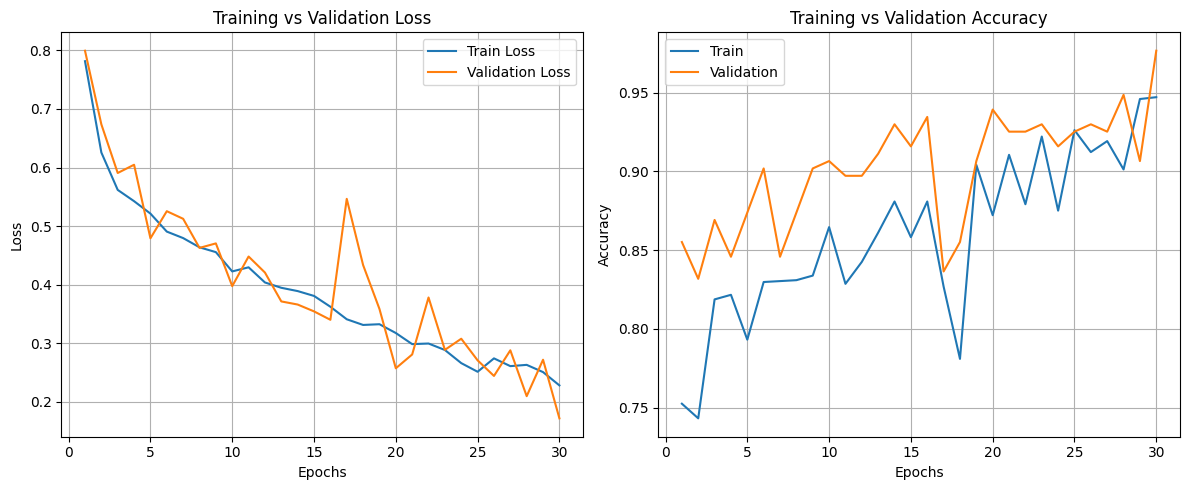

In [22]:
plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [23]:
labels_train,preds_train = evaluate(model,train_loader)
labels_val,preds_val = evaluate(model,val_loader)
labels_test,preds_test = evaluate(model,test_loader)

In [24]:
cm_train = confusion_matrix(labels_train,preds_train)
cm_val = confusion_matrix(labels_val,preds_val)
cm_test = confusion_matrix(labels_test,preds_test)

In [25]:
def plot_confusion_matrix(cm):
  class_labels = train_dataset.class_to_idx
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_labels,
          yticklabels=class_labels)
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.title("Confusion Matrix")
  plt.show()

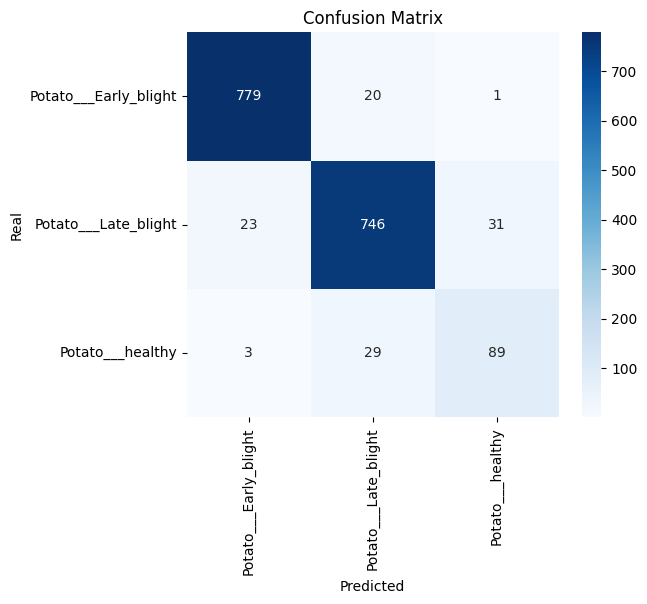

In [26]:
plot_confusion_matrix(cm_train)

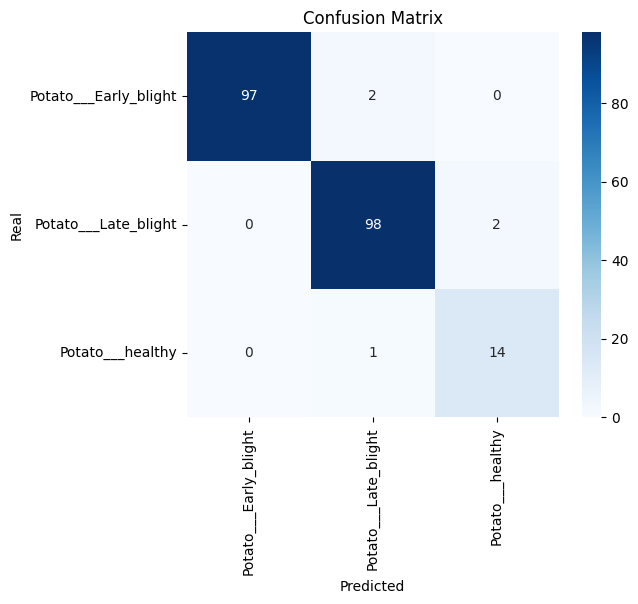

In [27]:
plot_confusion_matrix(cm_val)

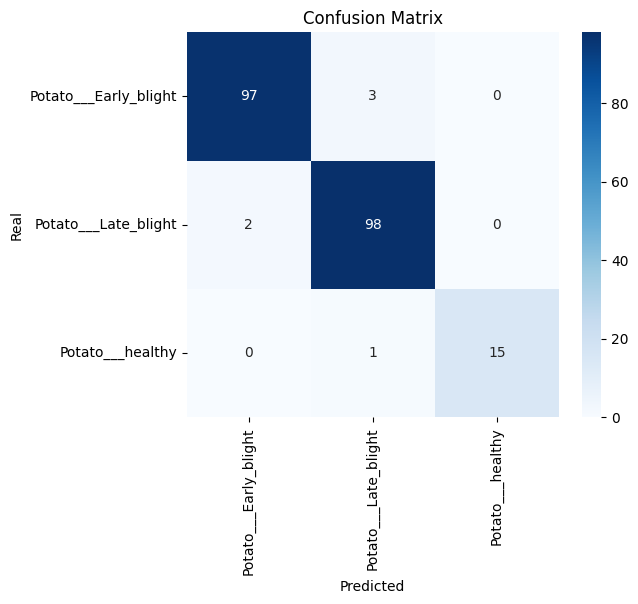

In [28]:
plot_confusion_matrix(cm_test)

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(labels_train,preds_train))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       800
           1       0.94      0.93      0.94       800
           2       0.74      0.74      0.74       121

    accuracy                           0.94      1721
   macro avg       0.88      0.88      0.88      1721
weighted avg       0.94      0.94      0.94      1721



In [31]:
print(classification_report(labels_val,preds_val))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        99
           1       0.97      0.98      0.98       100
           2       0.88      0.93      0.90        15

    accuracy                           0.98       214
   macro avg       0.95      0.96      0.96       214
weighted avg       0.98      0.98      0.98       214



In [32]:
print(classification_report(labels_test,preds_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.96      0.98      0.97       100
           2       1.00      0.94      0.97        16

    accuracy                           0.97       216
   macro avg       0.98      0.96      0.97       216
weighted avg       0.97      0.97      0.97       216



In [40]:
print(f"Train Acc: {accuracy(model,train_loader)}")
print(f"Val Acc: {accuracy(model,val_loader)}")
print(f"Test Acc: {accuracy(model,test_loader)}")

Train Acc: 0.9459616502033701
Val Acc: 0.9766355140186916
Test Acc: 0.9722222222222222


### **Predicciones**

In [41]:
idx =  {v: k for k, v in train_dataset.class_to_idx.items()}

In [42]:
idx

{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}

In [43]:
def mostrar_predicciones(model, data_dir, transforms, total_imagenes=15):
    """
    Muestra grid de imágenes con:
    - Etiqueta real
    - Etiqueta predicha
    - Probabilidad
    """

    todas_imagenes = []

    for clase in os.listdir(data_dir):
        clase_path = os.path.join(data_dir, clase)
        if os.path.isdir(clase_path):
            for img in os.listdir(clase_path):
                if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                    todas_imagenes.append(os.path.join(clase_path, img))

    seleccionadas = random.sample(todas_imagenes, min(total_imagenes, len(todas_imagenes)))

    num_cols = 5
    num_rows = (len(seleccionadas) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    axes = axes.flatten() if num_rows > 1 else [axes]

    model.eval()
    model = model.to(device)

    for i, img_path in enumerate(seleccionadas):

        # 🔹 Etiqueta real (nombre de la carpeta)
        real_clase = os.path.basename(os.path.dirname(img_path))

        # Cargar imagen
        img = Image.open(img_path).convert("RGB")
        x = transforms(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
            pred_idx = int(np.argmax(probs))
            pred_clase = idx[pred_idx]
            confidence = probs[pred_idx] * 100

        # ¿Acertó?
        correcto = (pred_clase == real_clase)

        # Color verde si acierta, rojo si falla
        color = '#2ecc71' if correcto else '#e74c3c'

        axes[i].imshow(img)
        axes[i].axis('off')

        axes[i].set_title(
            f"Real: {real_clase}\nPred: {pred_clase} ({confidence:.1f}%)",
            fontsize=9,
            fontweight='bold',
            color=color
        )

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Predicciones del Modelo", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

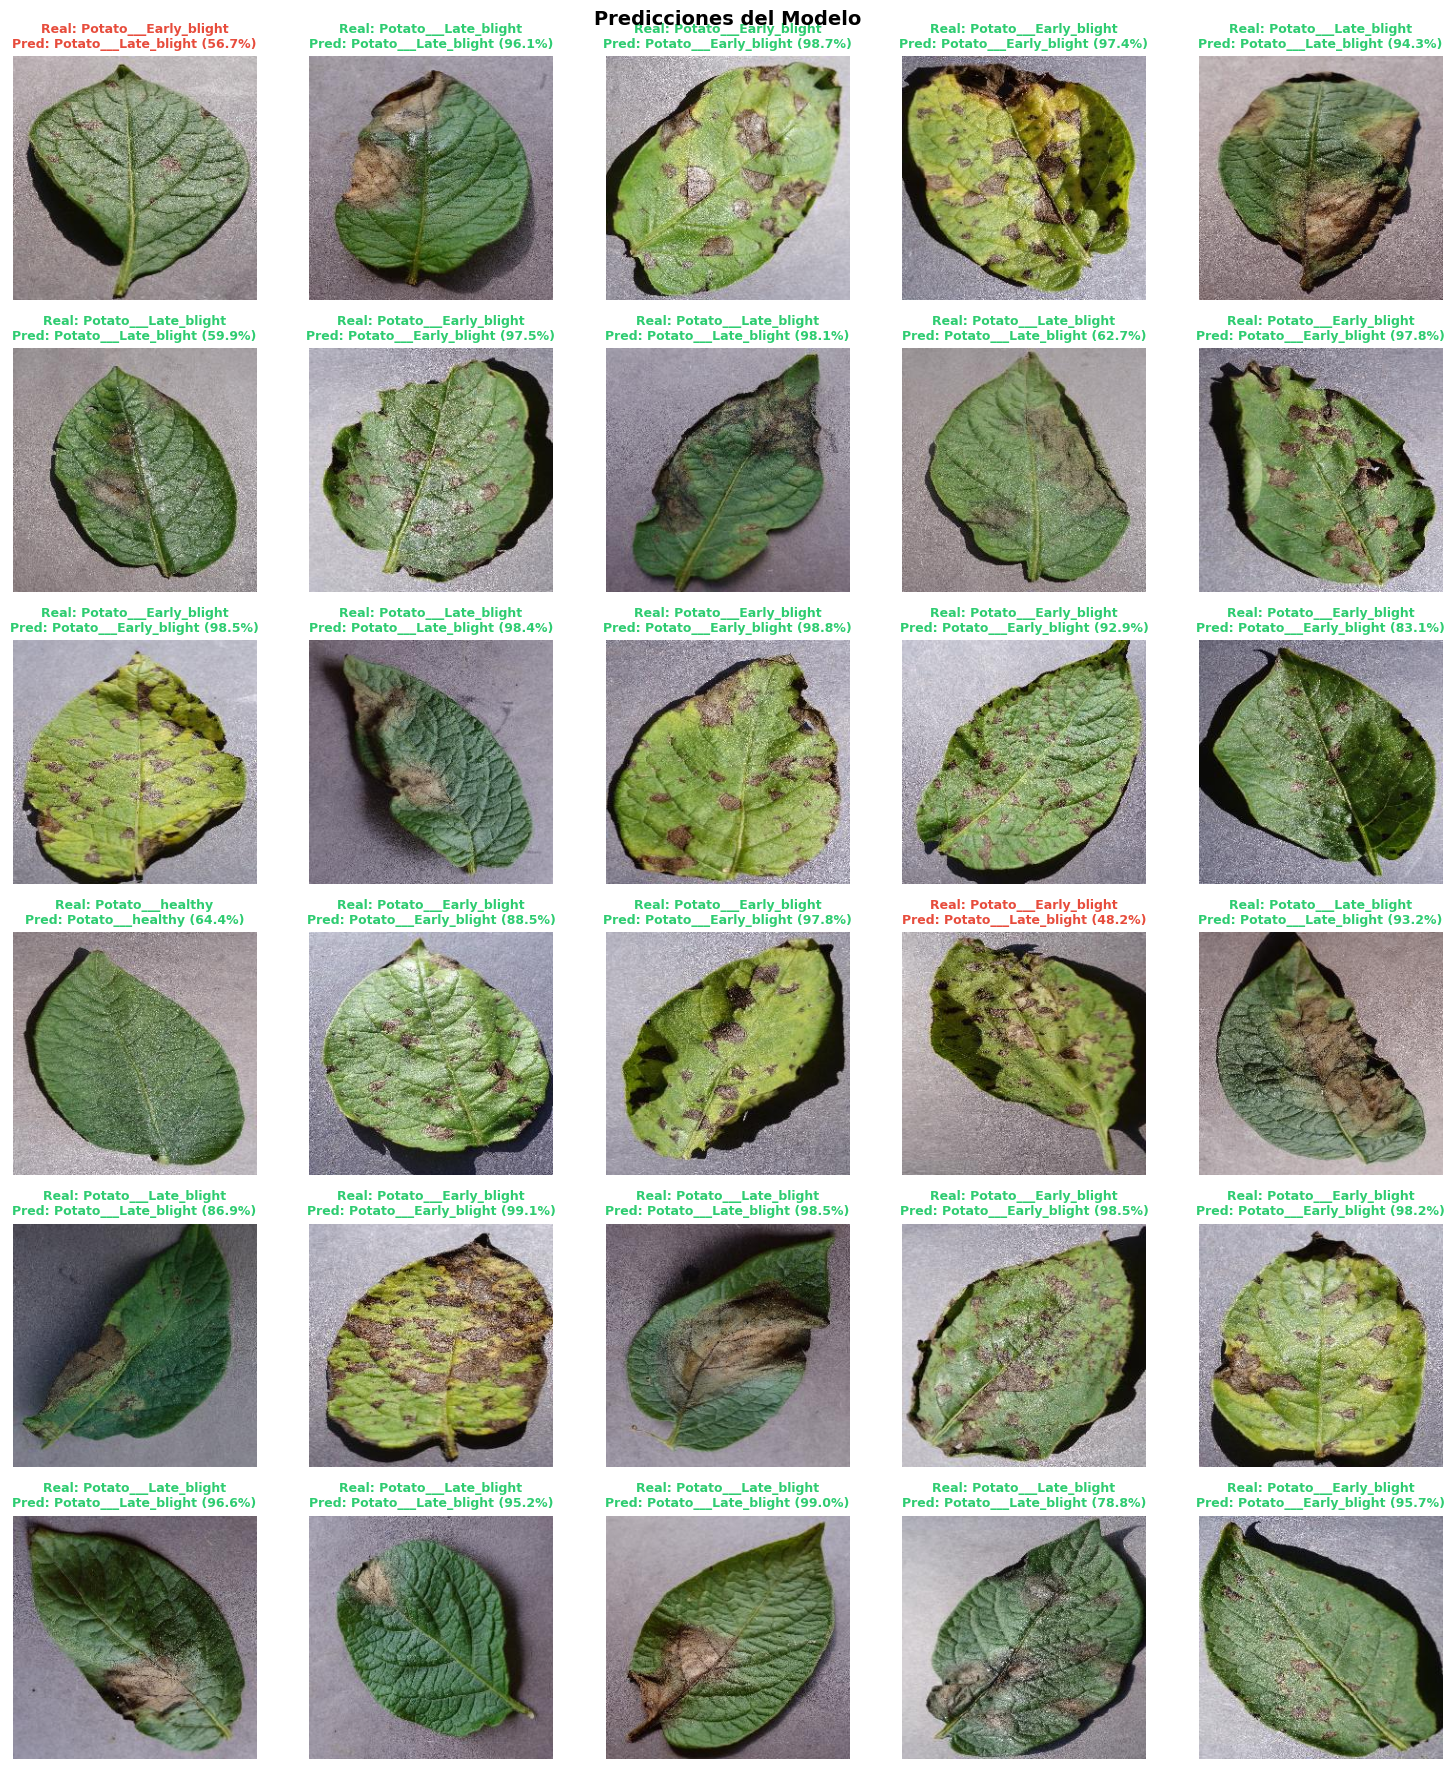

In [44]:

mostrar_predicciones(model, test_dir, val_transforms, total_imagenes=30)

## **Conclusión**

El modelo de red neuronal convolucional desarrollado para la clasificación de enfermedades en hojas de papa demuestra un desempeño sólido y consistente en la identificación de patrones visuales asociados a diferentes estados fitosanitarios del cultivo. A partir del análisis de la matriz de confusión, se observa que el modelo logra identificar correctamente la mayoría de las muestras, mostrando un rendimiento destacado en la diferenciación entre hojas sanas y aquellas afectadas por enfermedades.

El enfoque basado en aprendizaje profundo permitió al modelo extraer automáticamente características relevantes como variaciones de coloración, textura y patrones de daño presentes en las hojas, lo que contribuye a una clasificación precisa sin necesidad de ingeniería manual de características. Este comportamiento resulta especialmente valioso en aplicaciones agrícolas, donde la detección temprana de enfermedades permite implementar medidas preventivas oportunas y reducir pérdidas productivas.

El conjunto de datos utilizado proviene del dataset PlantVillage disponible en Kaggle, el cual fue recolectado bajo condiciones controladas y siguiendo un protocolo riguroso de adquisición de imágenes. Si bien esta estandarización mejora la calidad y consistencia de los datos, también implica que el modelo puede volverse sensible a características del entorno de captura, como el fondo uniforme de las imágenes. En consecuencia, el rendimiento del modelo podría variar al aplicarse en condiciones reales de campo, donde la iluminación, el ruido visual y la variabilidad del fondo son mayores.

Asimismo, la separación independiente de los conjuntos de entrenamiento, validación y prueba permitió evaluar de forma confiable la capacidad de generalización del modelo, evidenciando un comportamiento estable fuera de los datos utilizados durante el entrenamiento.

Adicionalmente, se observó que la clase Healthy, aunque visualmente suele ser la más sencilla de identificar, puede presentar ciertas confusiones cuando las enfermedades se encuentran en etapas iniciales y sus síntomas aún no son completamente visibles. Esto sugiere que, desde una perspectiva práctica, el sistema podría optimizarse enfocándose principalmente en la discriminación entre enfermedades activas, particularmente Early Blight y Late Blight, las cuales representan el mayor impacto agronómico. En este sentido, una posible estrategia futura consiste en replantear el problema hacia una clasificación centrada en estados de enfermedad, reduciendo o separando la categoría Healthy para mejorar la sensibilidad diagnóstica entre patologías.

En conjunto, los resultados indican que el modelo aprende patrones relevantes asociados a las enfermedades de la papa, convirtiéndose en una herramienta potencialmente útil para sistemas automatizados de monitoreo fitosanitario y apoyo en la toma de decisiones agrícolas. Sin embargo, para su implementación en escenarios reales, es recomendable entrenarlo con imágenes más diversas en cuanto a fondo y condiciones ambientales, con el fin de mejorar su robustez y capacidad de generalización.

En trabajos futuros, el desempeño podría mejorarse mediante el incremento del conjunto de datos en condiciones reales de campo, técnicas adicionales de aumento de datos específicas por enfermedad, el uso de modelos preentrenados de mayor capacidad o la implementación de esquemas de clasificación jerárquica orientados a la detección temprana de enfermedades críticas.

### **Guardar modelo**

In [45]:
torch.save(model.state_dict(), "potatoes_residualCNN.pth")